<a href="https://colab.research.google.com/github/Wairioko/Accounts-Receivables/blob/main/Accounts_Receivables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

In [81]:
# load data
accounts_receivables = pd.read_csv('/content/Accounts-Receivable.csv')
# dropping country code and invoice number column cause it doesn't provide meaningful insights
accounts_receivables = accounts_receivables.drop('countryCode', axis=1)
accounts_receivables = accounts_receivables.drop('invoiceNumber', axis=1)
# describe dataset
accounts_receivables.describe()

,InvoiceAmount,DaysToSettle,DaysLate
count,2466.000000,2466.00000,2466.000000
mean,59.895856,26.44485,3.442417
std,20.435838,12.33493,6.290607
min,5.260000,0.00000,0.000000
25%,46.400000,18.00000,0.000000
50%,60.560000,26.00000,0.000000
75%,73.765000,35.00000,5.000000
max,128.280000,75.00000,45.000000


# Data Summary
**Value**

From our data we can see that the average value of invoices in arrears is 60 dollars with the maximum and minimum being 128 and 5 dollars respectively.

**DaysLate**

The invoices are in arrears for an average of 3.44. The longest being 45 days and shortest being 0 days. 

**Settlement**

It takes on average 26.45 days for an invoice to be settled. 75 days being the lonngest its taken to settle and 0 days being the minimu meaning inivoice was paid on date of delivery

In [82]:
# create a new column to label all earlypayment before duedate
# convert the date columns to datetime format
accounts_receivables['InvoiceDate'] = pd.to_datetime(accounts_receivables['InvoiceDate'])
accounts_receivables['DueDate'] = pd.to_datetime(accounts_receivables['DueDate'])
accounts_receivables['SettledDate'] = pd.to_datetime(accounts_receivables['SettledDate'])

# create a new column 'earlypayment' with default value 0
accounts_receivables['earlypayment'] = 0

# find all items with SettledDate paid before DueDate and set 'earlypayment' to 1
accounts_receivables.loc[accounts_receivables['SettledDate'] < accounts_receivables['DueDate'], 'earlypayment'] = 1

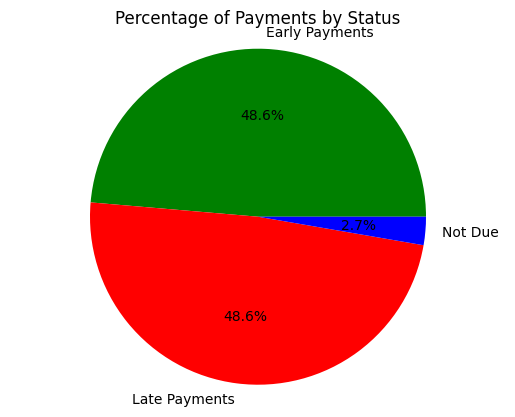

In [49]:
# Calculate percentage of early payments
num_early_payments = len(accounts_receivables[accounts_receivables['earlypayment'] == 1])
not_due_payments = len(accounts_receivables[(accounts_receivables['earlypayment'] == 0) &
                                            (accounts_receivables['DaysLate'] == 0) & 
                                            (accounts_receivables['DaysToSettle'] > 0)])
late_payments = len(accounts_receivables[accounts_receivables['DaysToSettle'] > 30])
total_payments = num_early_payments + not_due_payments + late_payments
early_payment_percentage = (num_early_payments / total_payments) * 100
late_payments_percentage = (late_payments/total_payments) * 100
not_due_percentage = (not_due_payments / total_payments) * 100
# Create a pie chart showing the percentage of early payments
labels = ['Early Payments', 'Late Payments', 'Not Due']
sizes = [early_payment_percentage, early_payment_percentage, not_due_percentage]
colors = ['green', 'red', 'blue']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Percentage of Payments by Status')
plt.axis('equal')
plt.show()

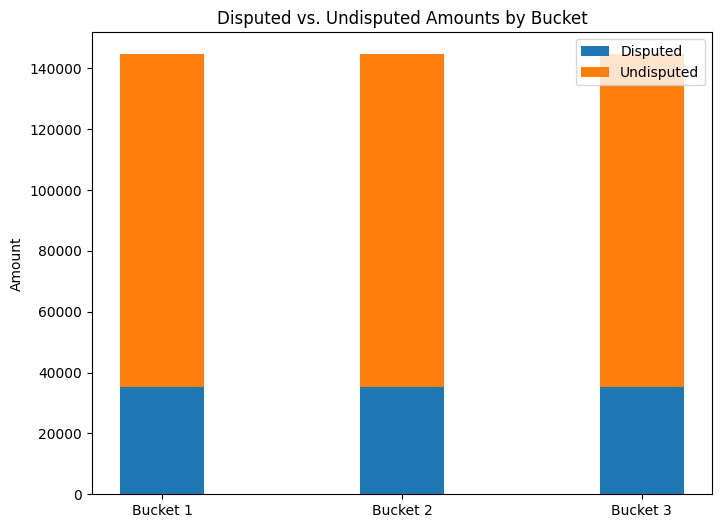

Bucket1: Value disputed in dollars 18598 (16%),  Undisputed value in dollars 97642 (84%),
Bucket2: Value disputed in dollars 7646 (47%),  Undisputed value in dollars 8403 (52%),
Bucket3: Value disputed in dollars 8975 (72%),  Undisputed value in dollars 3331 (27%),

Total value under dispute 35220,
 Total value under no dispute 109377
No Disputes:
Bucket 1: 89.00%
Bucket 2: 8.00%
Bucket 3: 3.00%
Disputes:
Bucket 1: 53.00%
Bucket 2: 22.00%
Bucket 3: 25.00%


In [76]:
# calculating total amounts overdue receivables and putting them in buckets
# buckets amounts are <7 days = buc1, <= 14 days = buc2 and >14 days = buc3
# getting value for each dispute category for each bucket
# bucket1
yes_buc1_disputes = accounts_receivables[(accounts_receivables['DaysLate'] < 7) & 
                                         (accounts_receivables['Disputed'] == 'Yes')][['InvoiceAmount']]
no_buc1_disputes = accounts_receivables[(accounts_receivables['DaysLate'] < 7) & 
                                         (accounts_receivables['Disputed'] == 'No')][['InvoiceAmount']]
# bucket2
yes_buc2_disputes = accounts_receivables[(accounts_receivables['DaysLate'] > 7) & (accounts_receivables['DaysLate'] <=14) 
                                         & (accounts_receivables['Disputed'] == 'Yes')][['InvoiceAmount']]
no_buc2_disputes = accounts_receivables[(accounts_receivables['DaysLate'] > 7) & (accounts_receivables['DaysLate'] <=14) 
                                         & (accounts_receivables['Disputed'] == 'No')][['InvoiceAmount']]
# bucket3
yes_buc3_disputes = accounts_receivables[(accounts_receivables['DaysLate'] > 14) & 
                                         (accounts_receivables['Disputed'] == 'Yes')][['InvoiceAmount']]
no_buc3_disputes = accounts_receivables[(accounts_receivables['DaysLate'] > 14) & 
                                         (accounts_receivables['Disputed'] == 'No')][['InvoiceAmount']]
# Calculate total amount for each group
yes_amounts = sum((yes_buc1_disputes.sum()[0], yes_buc2_disputes.sum()[0], yes_buc3_disputes.sum()[0]))
no_amounts = sum((no_buc1_disputes.sum()[0], no_buc2_disputes.sum()[0], no_buc3_disputes.sum()[0]))

buc1_no_percen = round((no_buc1_disputes.sum() / no_amounts), 2)
buc2_no_percen = round((no_buc2_disputes.sum() / no_amounts), 2)
buc3_no_percen = round((no_buc3_disputes.sum() / no_amounts), 2)

buc1_yes_percen = round((yes_buc1_disputes.sum() / yes_amounts), 2)
buc2_yes_percen = round((yes_buc2_disputes.sum() / yes_amounts), 2)
buc3_yes_percen = round((yes_buc3_disputes.sum() / yes_amounts), 2)


# get percentages
buc1_tot = yes_buc1_disputes.sum() + no_buc1_disputes.sum()
buc2_tot = yes_buc2_disputes.sum() + no_buc2_disputes.sum() 
buc3_tot = yes_buc3_disputes.sum() + no_buc3_disputes.sum()  
buc1_disputed_percentage = round((yes_buc1_disputes.sum() / buc1_tot) * 100, 2)
buc1_notdisputed_percentage = round(no_buc1_disputes.sum() / buc1_tot * 100, 2)
buc2_disputed_percentage = round(yes_buc2_disputes.sum() / buc2_tot * 100, 2)
buc2_notdisputed_percentage = round(no_buc2_disputes.sum() / buc2_tot * 100, 2)
buc3_disputed_percentage = round(yes_buc3_disputes.sum() / buc3_tot * 100, 2)
buc3_notdisputed_percentage = round(no_buc3_disputes.sum() / buc3_tot * 100, 2)
# Plot the data
fig, ax = plt.subplots(figsize=(8,6))
ind = [1,2,3]
width = 0.35
p1 = ax.bar(ind, yes_amounts, width)
p2 = ax.bar(ind, no_amounts, width, bottom=yes_amounts)

# Add labels and titles
ax.set_xticks(ind)
ax.set_xticklabels(['Bucket 1', 'Bucket 2', 'Bucket 3'])
ax.set_ylabel('Amount')
ax.set_title('Disputed vs. Undisputed Amounts by Bucket')
ax.legend((p1[0], p2[0]), ('Disputed', 'Undisputed'))

plt.show()

print('Bucket1: Value disputed in dollars {0} ({1}%),  Undisputed value in dollars {2} ({3}%),\n'
      'Bucket2: Value disputed in dollars {4} ({5}%),  Undisputed value in dollars {6} ({7}%),\n' 
      'Bucket3: Value disputed in dollars {8} ({9}%),  Undisputed value in dollars {10} ({11}%),\n'.format(
    int(yes_buc1_disputes.sum()),int(buc1_disputed_percentage), int(no_buc1_disputes.sum()), int(buc1_notdisputed_percentage), 
    int(yes_buc2_disputes.sum()),int(buc2_disputed_percentage), int(no_buc2_disputes.sum()), int(buc2_notdisputed_percentage),
    int(yes_buc3_disputes.sum()),int(buc3_disputed_percentage), int(no_buc3_disputes.sum()), int(buc3_notdisputed_percentage)))


print('Total value under dispute {},\n Total value under no dispute {}'.format(int(yes_amounts), int(no_amounts)))


print("No Disputes:")
print(f"Bucket 1: {buc1_no_percen[0]:.2%}")
print(f"Bucket 2: {buc2_no_percen[0]:.2%}")
print(f"Bucket 3: {buc3_no_percen[0]:.2%}")

print("Disputes:")
print(f"Bucket 1: {buc1_yes_percen[0]:.2%}")
print(f"Bucket 2: {buc2_yes_percen[0]:.2%}")
print(f"Bucket 3: {buc3_yes_percen[0]:.2%}")






# Disputed and Undisputed Claims
This section analyses the accounts receivables entries. It places the receivables in 3 buckets:


1. Bucket1 - receivables less than 7 days in arrears
2. Bucket2 - receivables in arrears for more than 7 days but less than 14 days
3. Bucket3 - receivables in arrears for over 14 days

We can see that the total value of *AR * under no dispute is 109,377 (75.64%) and under disputed *AR * valued at 35220(24.36%). 

***Disputed Arrears***

The value of invoices under disputed *AR * is valued at 35220(24.36% of total value).
we can see that according to the breakdown that :
Bucket 1: 53.00%
Bucket 2: 22.00%
Bucket 3: 25.00%

Further analysis would be required to see how many of those arrears in bucket1 that account for 53% of total disputed claims have been contacted in regards to the disputes which may be discrepancies about price, quantity, terms of sale and warranties. 
Determining the category of the dispute and the department that “owns” it. For instance, if the problem is pricing, is sales or order processing the culprit? If it’s quality, is manufacturing or shipping causing the issue. 

More data would be required to calculate the conversion rate, the  turning of these disputed claims to payments for each bucket and the decay rate of each of the uresolved claims from one bucket to another. 

***Undisputed Arrears***

The total value of *AR * under no dispute is 109,377 (75.64%). The breakdown is as follows:
Bucket 1: 89.00%
Bucket 2: 8.00%
Bucket 3: 3.00%

The focus with undisputed arrears should always be on getting them paid right away. Majority 89% lie in bucket 1. Key issues to investigate would be on the invoicing, when it's done, communication with clients to get feedback on payment delay,.  It would also be prudent to get data on the payment history of each of the customers in this bucket and model it to predict the credit default probabiity of every single one and forecast how this would affect the  cashflows and expected payments(cf) from the buckets.


In [40]:
# Logistic regression to determine how well amount, disputed, type of bill predict early payment

# convert 'Disputed'and 'PaperlessBill' columns into numerical form
accounts_receivables['Disputed'] = accounts_receivables['Disputed'].apply(lambda x: 1 if x=='Yes' else 0)
accounts_receivables['PaperlessBill'] = accounts_receivables['PaperlessBill'].apply(lambda x: 1 if x=='Electronic' else 0)

# Define the features and target variable
X = accounts_receivables[['InvoiceAmount', 'Disputed', 'PaperlessBill', 'DaysLate']]
y = accounts_receivables['earlypayment']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a linear regression model object
lr_model = LinearRegression()

# Fit the model to the training data
lr_model.fit(X_train, y_train)

# Predict the target variable using the testing data
y_pred = lr_model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Logistic Regression mean squared error: {:.2f}".format(mse))


# cross validation
# Use cross-validation to evaluate the model
scores = cross_val_score(lr_model , X, y, cv=12, scoring='neg_mean_squared_error')
mse_scores = -scores
# r2 squared to explain the variance between independent and dependent vars
# score of 100 or 1 indicates model explains the variance between the vars
R_score = r2_score(y_test, y_pred)
print("R Squared score: {}".format(R_score))
# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error: {:.2f}".format(mae))
# Print the mean squared error scores for each fold
print(mse_scores)
print("Cross validated Mean MSE:", mse_scores.mean())


Logistic Regression mean squared error: 0.13
R Squared score: 0.4672800179959947
Mean absolute error: 0.30
[0.12645787 0.12714297 0.14156269 0.12721143 0.13207845 0.12259188
 0.13319277 0.11645496 0.12437501 0.13466656 0.1101104  0.12319847]
Cross validated Mean MSE: 0.12658695507734907


# Linear Regression

The mean squared error (MSE) of 0.13 and the R-squared
score of 0.467, show that the linear regression model 
provides a moderate fit for predicting the dependent variable earlypayment.

The R-squared score of 0.467 suggests that the  independent variables explain approximately 47% of the variance in the dependent variable, indicating that there may be other important factors affecting early payment by customers which have not been included in this dataset such.

When cross-validating the model using a 12-fold cross-validation approach, the average MSE of 0.1265 is relatively consistent with the initial MSE, indicating that the model is not overfitting the training data.

The mean absolute error (MAE) of 0.30 suggests that the model's predictions are, on average, off by 30% in terms of early payment prediction.

Overall, this model provides a moderate fit for predicting early payments based on the given independent variables, but additional data points or more complex models may be necessary to improve the accuracy of the prediction including the use of hyperparameters which will not be explored in this project.